In [1]:
import numpy      as    np
import h5py       as    h5
import ismrmrd    as    mrd
import ismrmrd.xsd
from   matplotlib import   pyplot as plt
# import seaborn    as    sns

In [2]:
def returnHeaderAndData (h5RawFilePath, dataElement='/dataset'):

   rawDataArray = mrd.Dataset(h5RawFilePath, dataElement, True)
   rawDataArrayHeader = ismrmrd.xsd.CreateFromDocument(rawDataArray.read_xml_header())

   enc = rawDataArrayHeader.encoding[0]

   # Matrix size
   eNx = enc.encodedSpace.matrixSize.x
   eNy = enc.encodedSpace.matrixSize.y
   # eNz = enc.encodedSpace.matrixSize.z

   if enc.encodingLimits.slice != None:
      eNz = enc.encodingLimits.slice.maximum + 1
   else:
      eNz = 1

   if enc.encodingLimits.repetition != None:
      eNt = enc.encodingLimits.repetition.maximum + 1
   else:
      eNt = 1

   # This will pack k-space data into a numpy array with the following
   # data order / shape:
   #
   #    [coil, readout, phase_encode_1, phase_encode_2 or slice, time]
   #
   # This ordering may not be suitable for all, or even a majority of
   # applications.  But since this is a demonstration notebook, it
   # seemed to be a 'natural' way to unpack and organize the data from
   # the ISMRMRD raw file.

   allKspace = np.zeros((rawDataArray.read_acquisition(0).data.shape[0],
                         rawDataArray.read_acquisition(0).data.shape[1],
                         eNy, eNz, eNt), dtype=np.complex64)

   for i in range(rawDataArray.number_of_acquisitions()):
      thisAcq = rawDataArray.read_acquisition(i)
      allKspace[:, :, thisAcq.idx.kspace_encode_step_1, thisAcq.idx.slice, thisAcq.idx.contrast] = thisAcq.data

   return rawDataArrayHeader, allKspace


In [3]:
def computeAndPlot (array2Plot, quant='magnitude'):

    # from comment above, index 3 is the slice slot
   slices2Plot = array2Plot.shape[3]
   times2Plot  = array2Plot.shape[4]

   # print ("slices:   ", slices2Plot)
   # print ("time pts: ", times2Plot)

   imageCols = int(np.ceil(np.sqrt(slices2Plot)))
   imageRows = int(np.ceil(np.sqrt(slices2Plot))) * times2Plot

   plottedFigures = plt.figure(figsize=(12,18))

   for t in range(times2Plot):
      for s in range(slices2Plot):
         subImages = plottedFigures.add_subplot(imageRows, imageCols, ((t * imageRows * imageCols / times2Plot) + s + 1))

         if ((quant == 'angle') or (quant == 'phase')):
            reconnedImage = np.sum(np.angle(imageSpace[:, :, :, s, t]), axis=0)
         else:
            reconnedImage = np.sqrt(np.sum((abs(array2Plot[:, :, :, s, t])), axis=0))

         subImages.imshow(reconnedImage)


## First - read in (fully sampled) calibration data from array coil

In [4]:
calDataArrayHeader, calDataArray = returnHeaderAndData('./ScanArchive_20190529_090502374_converted.h5')

In [5]:
imageSpace = np.fft.fftshift(np.fft.fft2(calDataArray, axes=(1,2)), axes=(1,2))

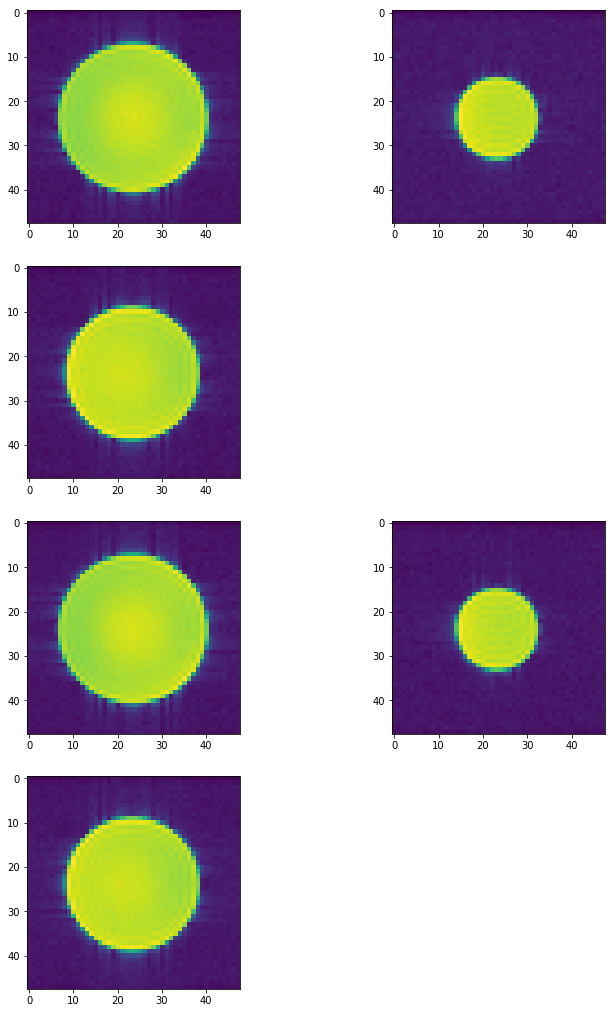

In [6]:
computeAndPlot(imageSpace)

## Now - read in data from body coil.  Not absolutely necessary - but might be useful

In [7]:
calDataBodyHeader, calDataBody = returnHeaderAndData('./ScanArchive_20190529_090622648_converted.h5')

In [8]:
imageSpace = np.fft.fftshift(np.fft.fft2(calDataBody, axes=(1,2)), axes=(1,2))

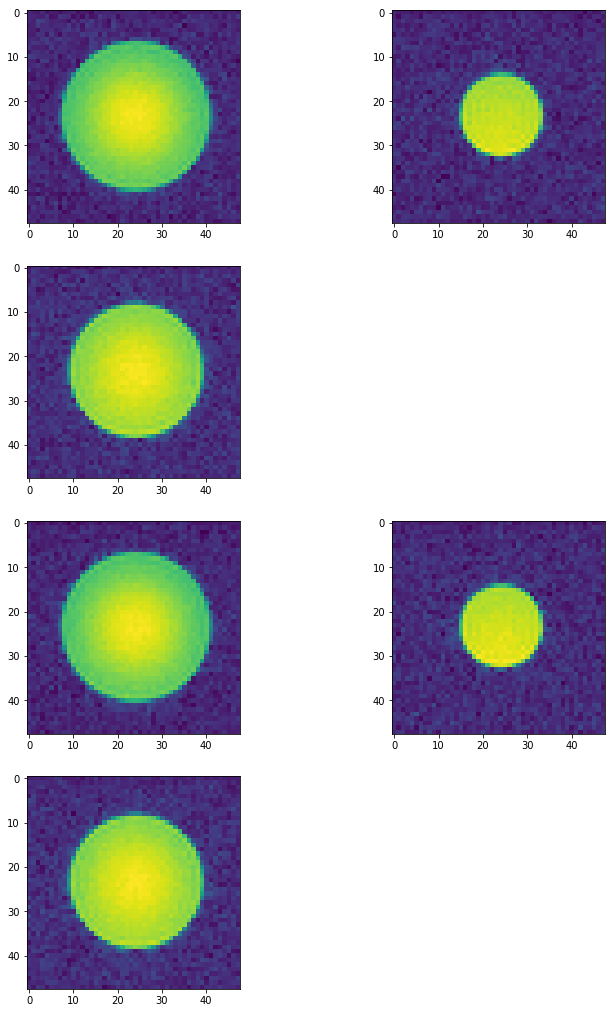

In [9]:
computeAndPlot(imageSpace)

In [10]:
imageSpace = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(calDataBody, axes=(1,2)), axes=(1,2)), axes=(1,2))

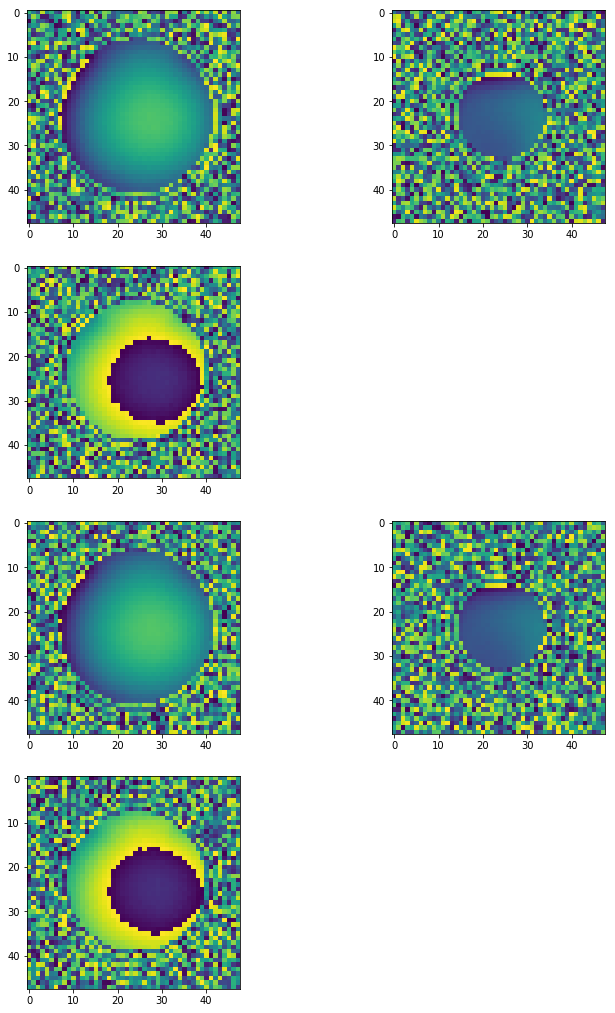

In [11]:
computeAndPlot(imageSpace, quant='phase')

## Read in noise data from array coil.  No need to reconstruct, but just as a sanity check.

In [12]:
noiseDataArrayHeader, noiseDataArray = returnHeaderAndData('./ScanArchive_20190529_090902358_converted.h5')

In [13]:
imageSpace = np.fft.fftshift(np.fft.fft2(noiseDataArray, axes=(1,2)), axes=(1,2))

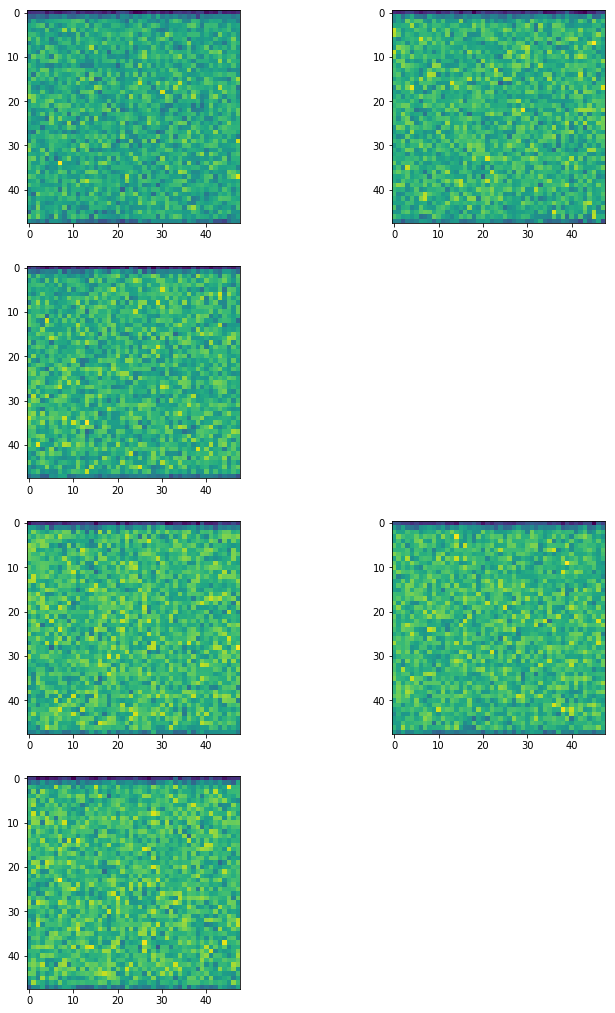

In [14]:
computeAndPlot(imageSpace)

In [15]:
enc = noiseDataArrayHeader.encoding[0]

rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

In [16]:
enc

In [17]:
rNx, rNy, rNz

(256, 256, 1)

### Create an artificially sub-sampled (accelerated) of data from the array coil data (R = 2)

In [18]:
subSampledKSpace = np.zeros((calDataArray.shape), dtype=np.complex64)

# subSampledKSpace = calDataArray[:, :, ::2, :, :]
subSampledKSpace[:, :, ::2, :, :] = calDataArray[:, :, ::2, :, :]

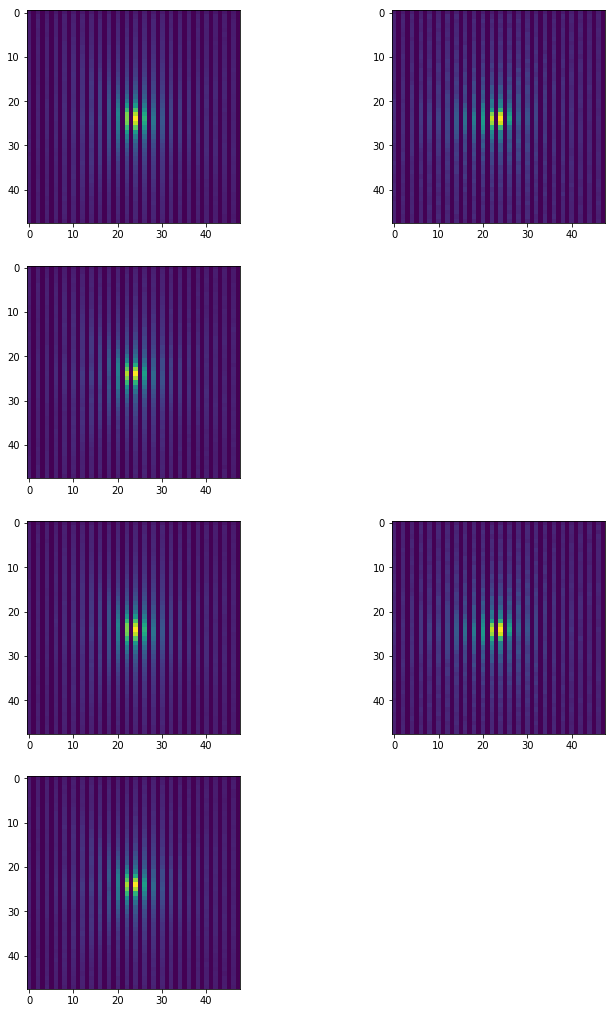

In [19]:
computeAndPlot(subSampledKSpace)

In [20]:
imageSpace = np.fft.fftshift(np.fft.fft2(subSampledKSpace, axes=(1,2)), axes=(1,2))

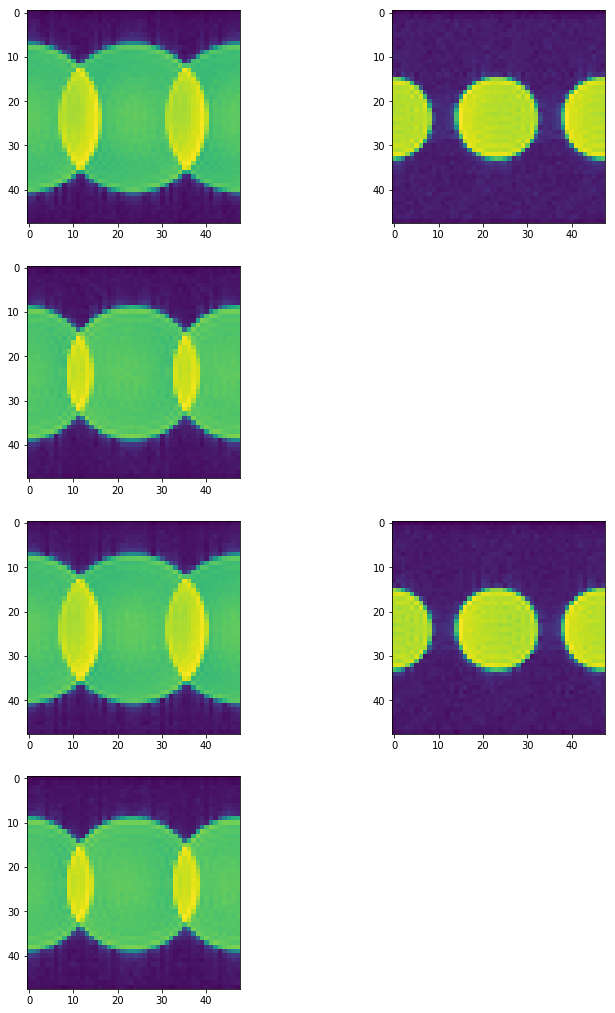

In [21]:
computeAndPlot(imageSpace)